# Least Core for Data Valuation

This notebook introduces Least Core methods for the computation of data values using pyDVL.

Whereas the Shapley values define a fair way to distribute data values amongst all data points when they the entire training set is used. But they do not consider the question of stability: Would some of the data points get a better payoff by forming smaller subsets?

The Core is another approach to compute data values originating in cooperative game theory that attempts to answer those questions. It is the set of feasible payoffs that cannot be improved upon by a coalition of the participants.

Its use for Data Valuation was first desribed in the paper [*If You Like Shapley Then You’ll Love the Core*](https://ojs.aaai.org/index.php/AAAI/article/view/16721) by Tom Yan and Ariel D. Procaccia.

The Least Core value $v$ of the $i$-th sample in dataset $D$ wrt. utility $u$ is computed
by solving the following Linear Program:

$$
\begin{array}{lll}
\text{minimize} & \displaystyle{e} & \\
\text{subject to} & \displaystyle\sum_{x_i\in D} v_u(x_i) = v_u(D) & \\
& \displaystyle\sum_{x_i\in S} v_u(x_i) + e \geq v_u(S) &, \forall S \subseteq D \\
\end{array}
$$

To illustrate this method we will use a synthetic dataset. We will first use a subset of 10 data point to compute the exact values and use them to assess the Monte Carlo approximation. Afterwards, we will conduct the data removal experiments as described by Ghorbani and Zou in their paper [Data Shapley: Equitable Valuation of Data for Machine Learning](https://arxiv.org/abs/1904.02868v1): We compute the data valuation given different computation budgets and incrementally remove a percentage of the best, respectively worst, data points and observe how that affects the utility.

## Setup

We begin by importing the main libraries and setting some defaults.

<div class="alert alert-info">
If you are reading this in the documentation, some boilerplate has been omitted for convenience.
</div>

In [1]:
%load_ext autoreload

In [2]:
%autoreload
%matplotlib inline

import logging
import os
import random
from typing import Dict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

plt.ioff()  # Prevent jupyter from automatically plotting
plt.rcParams["figure.figsize"] = (20, 8)
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 10

mean_colors = ["dodgerblue", "indianred", "limegreen", "darkorange", "darkorchid"]
shade_colors = ["lightskyblue", "firebrick", "seagreen", "gold", "plum"]

random_state = 16
random.seed(random_state)
np.random.seed(random_state)

is_CI = os.environ.get("CI")

if is_CI:
    enable_cache = False
    train_size = 10
    n_jobs = 1
else:
    enable_cache = True
    train_size = 200
    n_jobs = 4

We will be using the following functions and classes from pyDVL.

In [3]:
%autoreload
from pydvl.utils import (
    Dataset,
    Utility,
)
from pydvl.value.least_core import exact_least_core, montecarlo_least_core
from pydvl.reporting.plots import shaded_mean_std
from pydvl.reporting.scores import compute_removal_score, compute_random_removal_score

## Dataset

We generate a synthetic dataset using the [`make_classification`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html) function from scikit-learn.

We sample 200 data points from a 50-dimensional Gaussian distribution with 25 informative features and 25 non-informative features (generated as random linear combinations of the informative features).

The 200 samples are uniformly distributed across 3 classes with a small percentage of noise added to the labels to make the task a bit more difficult.

In [4]:
X, y = make_classification(
    n_samples=200,
    n_features=50,
    n_informative=25,
    n_classes=3,
    random_state=random_state,
)

In [5]:
full_dataset = Dataset.from_arrays(
    X, y, stratify_by_target=True, random_state=random_state
)
small_dataset = Dataset.from_arrays(
    X,
    y,
    stratify_by_target=True,
    train_size=10,
    random_state=random_state,
)

In [6]:
model = LogisticRegression(max_iter=500, solver="liblinear")

In [7]:
model.fit(full_dataset.x_train, full_dataset.y_train)
print(
    f"Training accuracy: {100 * model.score(full_dataset.x_train, full_dataset.y_train):0.2f}%"
)
print(
    f"Testing accuracy: {100 * model.score(full_dataset.x_test, full_dataset.y_test):0.2f}%"
)

Training accuracy: 86.25%
Testing accuracy: 70.00%


In [8]:
model.fit(small_dataset.x_train, small_dataset.y_train)
print(
    f"Training accuracy: {100 * model.score(small_dataset.x_train, small_dataset.y_train):0.2f}%"
)
print(
    f"Testing accuracy: {100 * model.score(small_dataset.x_test, small_dataset.y_test):0.2f}%"
)

Training accuracy: 100.00%
Testing accuracy: 47.89%


## Estimating Exact Least Core Values

In this first section we will use a smaller subset of the dataset containing 10 samples in order to be able to compute exact values in a reasonable amount of time. Afterwards, we will use the Monte Carlo method with a limited budget (maximum number of subsets) to approximate these values.

In [9]:
utility = Utility(model=model, data=small_dataset, enable_cache=False)

In [10]:
%%time
exact_values = exact_least_core(
    u=utility,
    progress=True,
)
exact_values

  0%|          | 0/1023 [00:00<?, ?it/s]

CPU times: user 4.01 s, sys: 8.97 s, total: 13 s
Wall time: 2.2 s


ValuationResult(algorithm='exact_least_core',status='converged',values=[0.04   0.0316 0.0868 0.0532 0.0289 0.04   0.0579 0.0479 0.0374 0.0553], least_core_value=0.28631578947368425)

In [11]:
exact_values_df = exact_values.to_dataframe(column="exact_value").T
exact_values_df = exact_values_df[sorted(exact_values_df.columns)]
exact_values_df

,0,1,2,3,4,5,6,7,8,9
exact_value,0.04,0.031579,0.086842,0.053158,0.028947,0.04,0.057895,0.047895,0.037368,0.055263
exact_value_stderr,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000


In [12]:
%%time
budget_array = np.linspace(200, 2 ** len(small_dataset), num=10, dtype=int)

all_estimated_values_df = []
all_errors = {budget: [] for budget in budget_array}

for budget in budget_array:
    dfs = []
    errors = []
    for i in range(30):
        column_name = f"estimated_value_{budget}"
        values = montecarlo_least_core(
            u=utility,
            max_iterations=budget,
            n_jobs=n_jobs,
            progress=False,
        )
        df = (
            values.to_dataframe(column=column_name)
            .drop(columns=[f"{column_name}_stderr"])
            .T
        )
        df = df[sorted(df.columns)]
        error = mean_squared_error(
            exact_values_df.loc["exact_value"].values, df.values.ravel()
        )
        all_errors[budget].append(error)
        df["budget"] = budget
        dfs.append(df)
    estimated_values_df = pd.concat(dfs)
    all_estimated_values_df.append(estimated_values_df)

values_df = pd.concat(all_estimated_values_df)
errors_df = pd.DataFrame(all_errors)

CPU times: user 16.7 s, sys: 1.5 s, total: 18.2 s
Wall time: 1min 31s


In [13]:
_ = shaded_mean_std(
    errors_df,
    abscissa=errors_df.columns,
    num_std=1,
    xlabel="Budget",
    ylabel="$l_2$ Error",
    label="Estimated values",
    title="$l_2$ approximation error of values as a function of the budget",
)

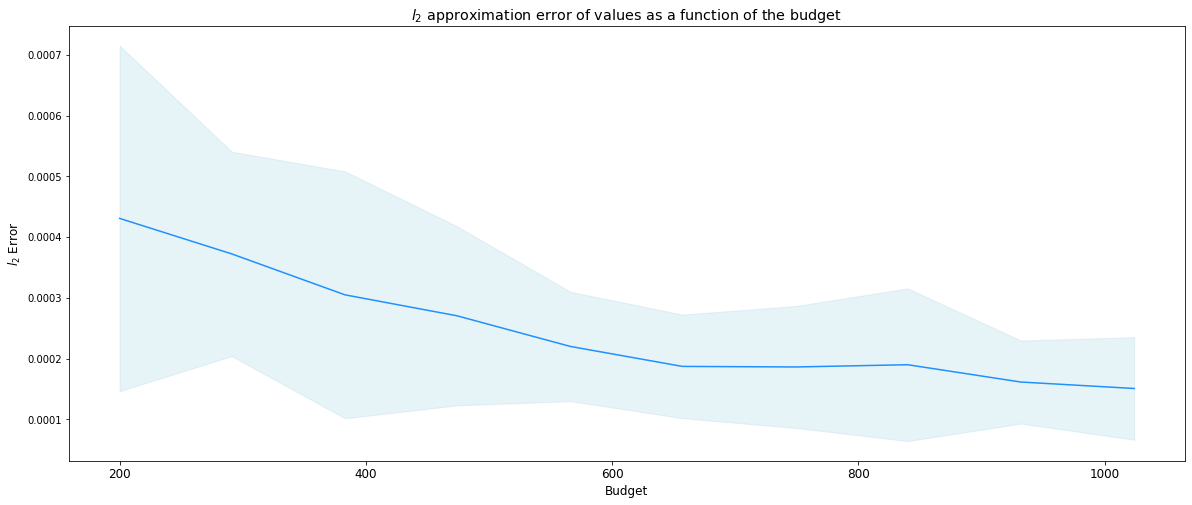

In [14]:
plt.show()

We can see that the approximation error decreases, on average, as the we increase the budget. 

Still, the decrease may not always necessarily happen when we increase the number of iterations because of the fact that we sample the subsets with replacement in the Monte Carlo method i.e there may be repeated subsets.

In [15]:
mean_std_values_df = values_df.drop(columns="budget").agg(["mean", "std"])
pd.concat([exact_values_df, mean_std_values_df]).T.plot(
    kind="bar",
    title="Comparison of Exact and Monte Carlo Methods",
    xlabel="Index",
    ylabel="Value",
    color=["dodgerblue", "indianred"],
    y=["exact_value", "mean"],
    yerr=[exact_values_df.loc["exact_value_stderr"], mean_std_values_df.loc["std"]],
)
_ = plt.legend(["Exact", "Monte Carlo"])

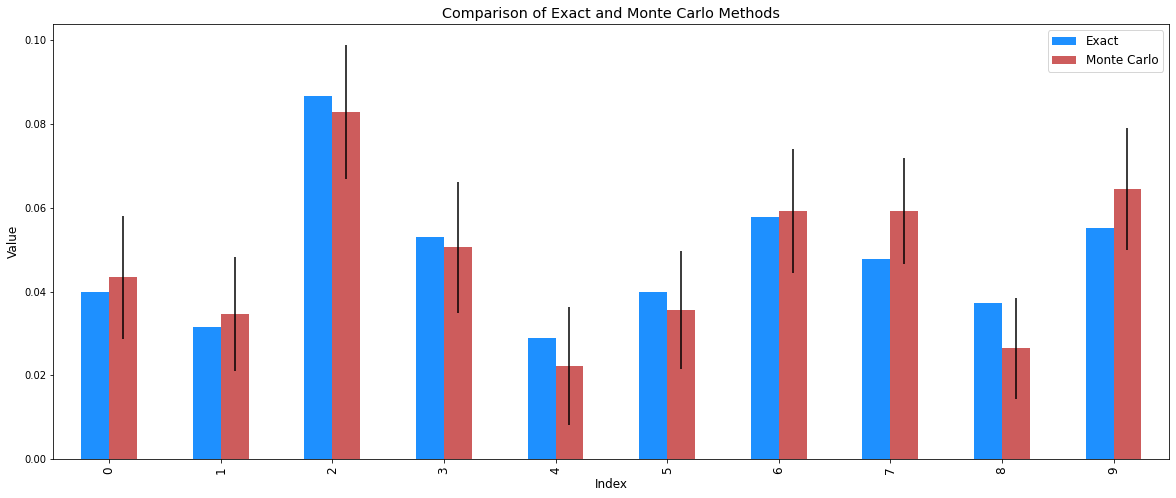

In [16]:
plt.show()

## Data Removal

We now move on to the data removal experiments using the full dataset.

In this set of experiments, the data instances are ranked from most valuable 
to least valuable using the Monte Carlo Least Core method, 
then we gradually remove 5 percent of the most valuable/least valuable ones,
train the model on this subset and compute its accuracy.

In [17]:
utility = Utility(model=model, data=full_dataset, enable_cache=False)

In [18]:
budget_array = ["Random", 5000, 10000, 25000, 50000]
removal_percentages = np.arange(0, 0.41, 0.05)

### Remove Best

We start by removing the best data instances and seeing how the model's accuracy evolves.

> **NOTE**: The following cell will take a long time to finish (~30 minutes).

In [19]:
%%time
all_scores = []

for budget in budget_array:
    for i in range(5):
        if budget == "Random":
            scores = compute_random_removal_score(
                u=utility, percentages=removal_percentages
            )
        else:
            values = montecarlo_least_core(
                u=utility,
                max_iterations=budget,
                n_jobs=n_jobs,
                progress=False,
            )
            scores = compute_removal_score(
                u=utility,
                values=values,
                percentages=removal_percentages,
                remove_best=True,
            )
        scores["budget"] = budget
        all_scores.append(scores)

scores_df = pd.DataFrame(all_scores)

CPU times: user 2min 18s, sys: 6.49 s, total: 2min 25s
Wall time: 16min 19s


In [20]:
fig, ax = plt.subplots()

for i, budget in enumerate(budget_array):
    shaded_mean_std(
        scores_df[scores_df["budget"] == budget].drop(columns=["budget"]),
        abscissa=removal_percentages,
        mean_color=mean_colors[i],
        shade_color=shade_colors[i],
        xlabel="Percentage Removal",
        ylabel="Accuracy",
        label=f"{budget}",
        title="Accuracy as a function of percentage of removed best data instances",
        ax=ax,
    )

_ = plt.legend()

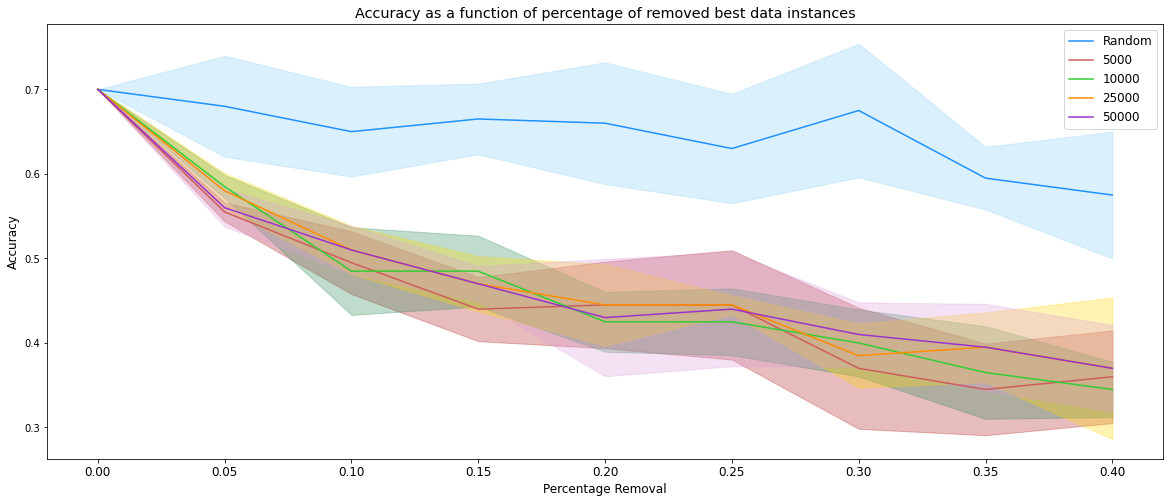

In [21]:
plt.show()

We can clearly see that removing the most valuable data instances, as given by the Least Core method, leads to, on average, a decrease in the model's performance and that the method outperforms a random removal.

We can also see that an increase in the budget does not necessarily lead to an improvement in the removal results. This could be due to the simple nature of the dataset or to the fact that we sample the subsets with replacement in the Monte Carlo method i.e there may be repeated subsets.

### Remove Worst

We then proceed to removing the worst data instances and seeing how the model's accuracy evolves.

> **NOTE**: The following cell will take a long time to finish (~30 minutes).

In [22]:
%%time
all_scores = []

for budget in budget_array:
    for i in range(5):
        if budget == "Random":
            scores = compute_random_removal_score(
                u=utility, percentages=removal_percentages
            )
        else:
            values = montecarlo_least_core(
                u=utility,
                max_iterations=budget,
                n_jobs=n_jobs,
                progress=False,
            )
            scores = compute_removal_score(
                u=utility,
                values=values,
                percentages=removal_percentages,
            )
        scores["budget"] = budget
        all_scores.append(scores)

scores_df = pd.DataFrame(all_scores)

CPU times: user 2min 20s, sys: 6.36 s, total: 2min 26s
Wall time: 16min 34s


In [23]:
fig, ax = plt.subplots()

for i, budget in enumerate(budget_array):
    shaded_mean_std(
        scores_df[scores_df["budget"] == budget].drop(columns=["budget"]),
        abscissa=removal_percentages,
        mean_color=mean_colors[i],
        shade_color=shade_colors[i],
        xlabel="Percentage Removal",
        ylabel="Accuracy",
        label=f"{budget}",
        title="Accuracy as a function of percentage of removed worst data instances",
        ax=ax,
    )
_ = plt.legend()

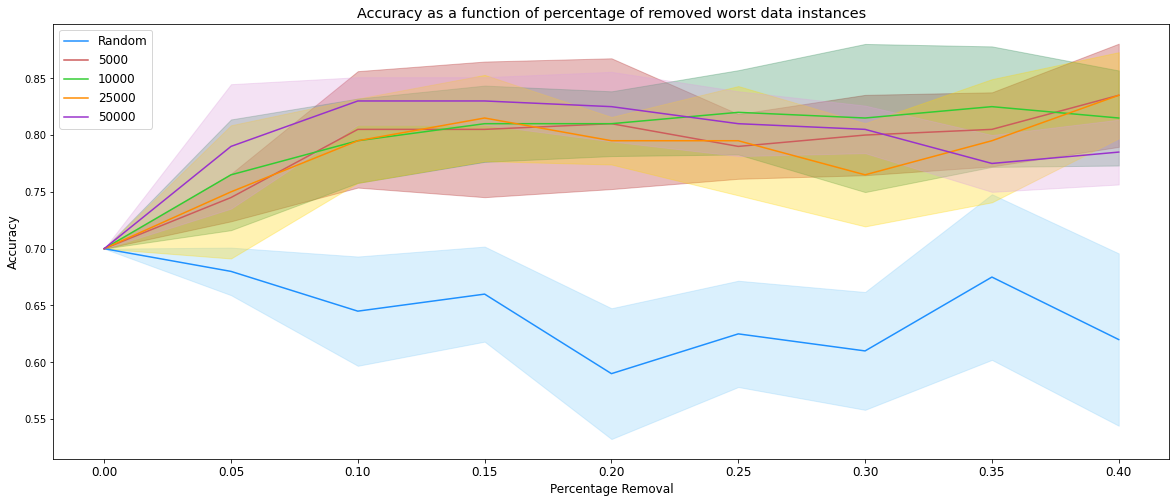

In [24]:
plt.show()

We can clearly see that removing the least valuable data instances, as given by the Least Core method, leads to, on average, an increase in the model's performance and that the method outperforms a random removal.

We can also see that an increase in the budget does not necessarily lead to an improvement in the removal results. This could be due to the simple nature of the dataset or to the fact that we sample the subsets with replacement in the Monte Carlo method i.e there may be repeated subsets.